# Medical Data Visualisation

Now that we've got a dataset enumerating the medical-related terms in the corpus, and their categories, we can start to analyse the fragments.

We're going to use [Vega and Vega Lite](https://vega.github.io/vega-lite/) for data visualisation, via the [Altair](https://altair-viz.github.io/) Python wrapper. Altair basically provides a Python API for generating Vega-Lite JSON visualisation description documents. Jupyter notebooks know how to render Altair objects.

In [2]:
import altair as alt
import pandas as pd

alt.data_transformers.enable('json')

/home/hal/.local/share/virtualenvs/genizah-visualisation-mG8BC0xT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hal/.local/share/virtualenvs/genizah-visualisation-mG8BC0xT/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


DataTransformerRegistry.enable('json')

In [3]:
token_types = pd.read_csv('../medical-data/token-types.csv', index_col='token')
token_types.head()

,type
token,
abcess,ailment
abcesses,ailment
abdomen,body_part
abdominal,body_part
abnormal,ailment


In [4]:
fragment_tokens = pd.read_csv('../medical-data/fragment-tokens.csv')
fragment_tokens.head()

,classmark,token
0,MS-OR-01080-00001-00063,pharmacopoeia
1,MS-OR-01080-00001-00063,containing
2,MS-OR-01080-00001-00063,diagram
3,MS-OR-01080-00001-00063,and
4,MS-OR-01080-00001-00063,symbol


In [5]:
fragment_tokens = pd.merge(fragment_tokens, token_types, 
                  left_on='token', right_index=True,
                  sort=False, validate='m:1')
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [6]:
fragments = pd.read_json('../medical-data/genizah-medical.json', orient='index')
fragments.index.name = 'classmark'
fragments = fragments.reset_index()
fragments.head()

,classmark,columns,date_end,date_start,height,lines,material,summary,title,width
0,MS-OR-01080-00001-00063,1.0,1899-12-31,0500-01-01,21.2,21.0,paper,"Pharmacopoeia, containing diagrams and symbols...",Medical,14.3
1,MS-OR-01080-00001-00072,1.0,1899-12-31,0500-01-01,36.4,22.0,vellum,"Discussion of various medical treatments, regi...",Medical,16.8
2,MS-OR-01080-00001-00081,1.0,1899-12-31,0500-01-01,25.4,12.0,paper,"Medical work on the composition of the body, c...",Medical,16.8
3,MS-OR-01080-00001-00087,1.0,1233-12-31,1213-01-01,NaN,5.0,paper,Recto: a short medical recipe. Verso: a respon...,Medical,NaN
4,MS-OR-01080-00002-00070,1.0,1199-12-31,1100-01-01,31.5,35.0,paper,Autograph draft of a medical work by Moses Mai...,Medical,22.8


In [7]:
fragments.shape

(1565, 10)

## Fragment Materials

The distribution of the materials manuscripts are made from makes for an easy starting point. We can create a table of materials and the number of times they occur, and plot a bar chart using Altair:

In [8]:
material_counts = (pd.DataFrame(fragments.groupby('material').size(), columns=['count'])
    .reset_index())
material_counts

,material,count
0,cardboard,1
1,cloth,2
2,paper,1490
3,vellum,71


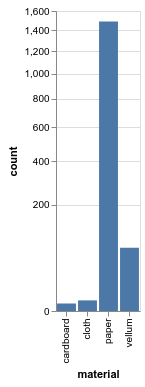

In [9]:
alt.Chart(material_counts).mark_bar().encode(
    alt.X('material:N'),
    # We'll use a non-linear scale, as the range is quite large.
    # Unfortunatley we don't get useful ticks at the bottom end
    # of the scale by default though...
    y=alt.Y('count:Q', scale=alt.Scale(type='pow', exponent=0.5)),
    tooltip='count'
)

## Fragment Sizes

Vega-Lite supports interactive charts. Each point on this scatterplot is a fragment, placed according to its width and height, and coloured according to the number of lines of text it holds. It can be panned and zoomed with a mouse.

As you'd expect, larger fragments tend to have more lines.

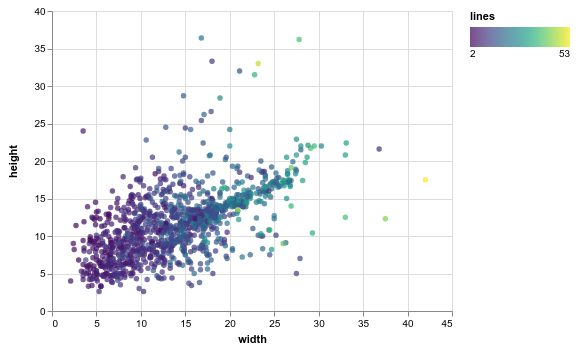

In [10]:
alt.Chart(fragments).mark_circle().encode(
    alt.X('width:Q'),
    alt.Y('height:Q'),
    color=alt.Color('lines:Q', bin=False, scale=alt.Scale(scheme='viridis')),
    tooltip='classmark'
).interactive()

## Tokens

### Token Types

In [11]:
fragment_tokens.head()

,classmark,token,type
0,MS-OR-01080-00001-00063,pharmacopoeia,treatment
177,MS-MOSSERI-III-00085-00001,pharmacopoeia,treatment
1498,MS-TS-AR-00039-00020,pharmacopoeia,treatment
1730,MS-TS-AR-00039-00091,pharmacopoeia,treatment
3411,MS-TS-AR-00039-00462,pharmacopoeia,treatment


In [12]:
tokens_per_type = (fragment_tokens[['type', 'token']].drop_duplicates()
    .groupby(['type'])
    .count())
fragments_per_type = (fragment_tokens[['type', 'classmark']].drop_duplicates()
    .groupby(['type'])
    .count())

for df in [tokens_per_type, fragments_per_type]:
    df.rename(columns=lambda c: 'count', inplace=True)

tokens_per_type['count_type'] = 'tokens'
fragments_per_type['count_type'] = 'fragments'

token_type_counts = (pd.concat([tokens_per_type, fragments_per_type], sort=False))
token_type_counts

,count,count_type
type,,
ailment,402,tokens
authority,48,tokens
body_part,185,tokens
ingredient,468,tokens
treatment,208,tokens
ailment,799,fragments
authority,329,fragments
body_part,724,fragments
ingredient,542,fragments


In [13]:
def display_values(field=None, mapping=None, display_field_name=None):
    if display_field_name is None:
        display_field_name = f'{field}_display'
    
    lookup_frame = pd.DataFrame.from_records(list(mapping.items()), columns=[field, display_field_name])
    return alt.LookupData(data=lookup_frame, key=field, fields=[display_field_name])

In [14]:
type_display_tx = display_values('type', {
    'ailment': 'Ailment',
    'authority': 'Authority',
    'body_part': 'Body part',
    'ingredient': 'Ingredient',
    'treatment': 'Treatment'
})
count_type_display_tx = display_values('count_type', {
    'fragments': 'Fragments',
    'tokens': 'Tokens'
})

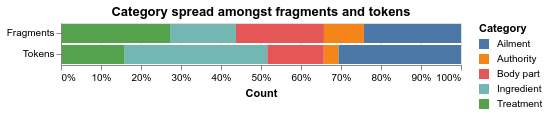

In [15]:
(alt.Chart(token_type_counts.reset_index(), title='Category spread amongst fragments and tokens')
  .mark_bar()
  .encode(
    alt.X('count:Q', axis=alt.Axis(title='Count', format='%'), stack='normalize'),
    alt.Y('count_type_display:N', axis=alt.Axis(title=None)),
    color=alt.Color('type_display:N', title='Category'),
    tooltip=['count:Q']
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
  .transform_lookup(lookup='count_type', from_=count_type_display_tx))

## Token usage frequency

In [16]:
fragments_per_token = (pd.DataFrame(fragment_tokens.groupby('token').size(), 
                                    columns=['count']))
fragments_per_token = fragments_per_token.merge(token_types, left_index=True, right_index=True)
fragments_per_token.sort_values(by='count', ascending=False).head()

,count,type
token,,
eye,155,body_part
medicine,150,treatment
disease,142,ailment
fever,132,ailment
body,115,body_part


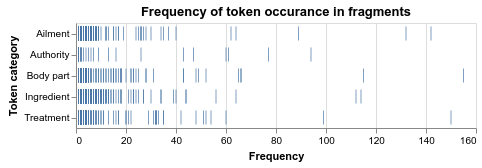

In [17]:
(alt.Chart(fragments_per_token, title='Frequency of token occurance in fragments')
  .mark_tick()
  .encode(
      alt.X('count:Q', title='Frequency'),
      alt.Y('type_display:N', title='Token category')
  )
  .transform_lookup(lookup='type', from_=type_display_tx)
)

## Top Terms

Wordcloud visualising terms. Terms are coloured according to category and sized according to number of fragments they appear in.

In [18]:
term_occurrences = (pd.merge(
        pd.DataFrame(fragment_tokens.groupby('token').aggregate('size'), columns=['occurrences']), 
        fragment_tokens[['token', 'type']].drop_duplicates(), 
        left_index=True, right_on='token')
    # Seems that Vega doesn't lay out the word cloud correctly if the text field isn't called "text".
    # Perhaps there's a default value referencing the text field, but I couldn't find one...
    .rename(columns={'token': 'text'}))
term_occurrences.text = term_occurrences.text.str.upper()
(term_occurrences.to_csv('./vega-term-occurrences.csv', index=False))

(term_occurrences
     .sort_values(['occurrences', 'text'], ascending=False)
     .head())

,occurrences,text,type
1377,155,EYE,body_part
467,150,MEDICINE,treatment
563,142,DISEASE,ailment
43,132,FEVER,ailment
51,115,BODY,body_part


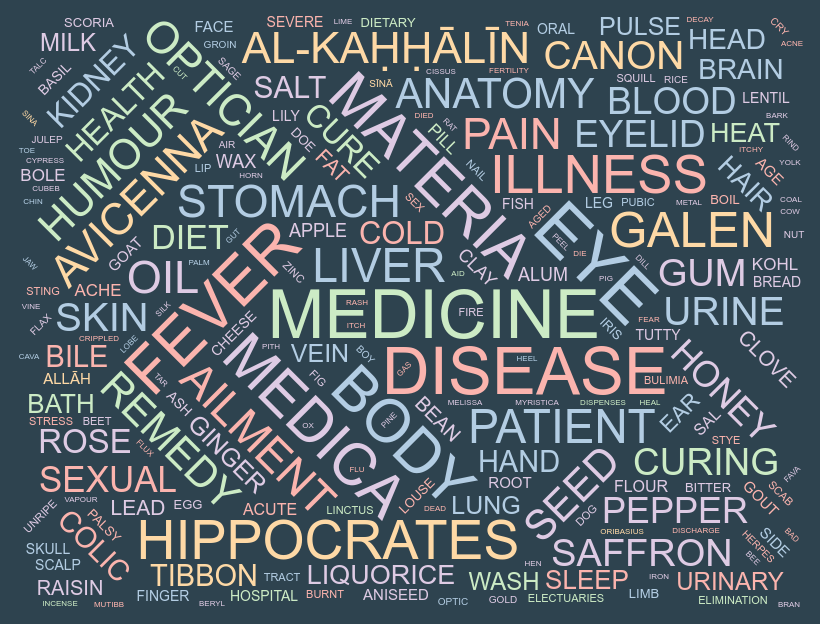

In [19]:
# Vega lite doesn't support word clouds, but Vega itself does, so we'll use that directly.

# Based on Vega's Word Cloud example: https://vega.github.io/vega/examples/word-cloud/
term_occurrences_wordcloud_json = {
  "$schema": "https://vega.github.io/schema/vega/v3.json",
  "width": 800,
  "height": 600,
  "padding": 10,
  "config": {
    "background": "#2e434f"  
  },
  "data": [
    {
      "name": "term-occurrences", 
      "url": "vega-term-occurrences.csv",
      "format": {"type": "csv"},
      "transform": [
        {
          "type": "formula", "as": "angle",
          "expr": "[-45, 0, 45][round(random() * 3)]"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "term-occurrences", "field": "type"},
      "range": {"scheme": "pastel1"}
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "term-occurrences"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "type"}
        },
        "update": {
          "fillOpacity": {"value": 1}
        },
        "hover": {
          "fillOpacity": {"value": 0.65}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [800, 600],
          "text": {"field": "text"},
          "rotate": {"field": "datum.angle"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.occurrences"},
          "fontSizeRange": [8, 56],
          "padding": 2
        }
      ]
    }
  ]
}

import altair.vega.v3
alt.vega.v3.vega(term_occurrences_wordcloud_json)

### Top terms table

List the most frequently appearing terms in each category.

In [20]:
(term_occurrences.groupby('type')
     .apply(lambda g: g.sort_values(['occurrences', 'text'], ascending=[False, True])
                       .assign(rank=range(1, len(g) + 1)))
     .set_index(['type', 'rank'])
     .unstack(0)
     .swaplevel(0, 1, axis=1)
     .sort_index(1)
     .head(30))

type     ailment                 authority                 body_part  \
     occurrences          text occurrences          text occurrences   
rank                                                                   
1          142.0       DISEASE        94.0   HIPPOCRATES       155.0   
2          132.0         FEVER        77.0         GALEN       115.0   
3           89.0       ILLNESS        61.0      AVICENNA        66.0   
4           64.0       AILMENT        60.0   AL-KAḤḤĀLĪN        66.0   
5           62.0          PAIN        47.0         CANON        65.0   
6           40.0       SYMPTOM        43.0    MAIMONIDES        52.0   
7           37.0        SEXUAL        26.0        TIBBON        49.0   
8           35.0      HEADACHE        16.0        DOCTOR        48.0   
9           34.0  INFLAMMATION        13.0       GALENIC        43.0   
10          30.0     DIARRHOEA         9.0   DIOSCORIDES        43.0   
11          28.0          COLD         7.0      DRUGGIST        31.0   
12          27.0         ULCER         6.0         ALLĀH        28.0   
13          26.0         COLIC         5.0   HIPPOCRATIC        28.0   
14          26.0         COUGH         4.0     ARISTOTLE        25.0   
15          26.0         WOUND         3.0  ARISTOLOCHIA        24.0   
16          25.0          BILE         2.0      AVERROES        23.0   
17          24.0       ABSCESS         2.0       FEBRIUM        23.0   
18          19.0         SLEEP         2.0        JUMAYʿ        22.0   
19          17.0      CATARACT         2.0       MEDENDI        22.0   
20          17.0       URINARY         2.0          SĪNĀ        20.0   
21          16.0      VOMITING         1.0   AESCULAPIUS        18.0   
22          15.0     DIGESTION         1.0      AFFECTIS        18.0   
23          15.0     PATHOLOGY         1.0   AL-KAḤḤALĪN        18.0   
24          13.0      APPETITE         1.0    AL-KAḤḤLĪN        18.0   
25          12.0          BITE         1.0     AL-KAḤḤĀL        17.0   
26          12.0       CHRONIC         1.0      AL-KINDĪ        16.0   
27          12.0           FAT         1.0     ALCHEMIST        16.0   
28          10.0     SUFFERING         1.0         ANIMA        15.0   
29           9.0      ALOPECIA         1.0    APPRENTICE        15.0   
30           9.0      JAUNDICE         1.0    ARCHIGENES        15.0   

type             ingredient                treatment                    
           text occurrences         text occurrences              text  
rank                                                                    
1           EYE       114.0       MEDICA       150.0          MEDICINE  
2          BODY       112.0      MATERIA        99.0     PHARMACOPOEIA  
3         LIVER        64.0          OIL        60.0          OPTICIAN  
4       PATIENT        56.0         SEED        54.0            HUMOUR  
5       STOMACH        44.0          GUM        52.0            REMEDY  
6       ANATOMY        44.0      SAFFRON        51.0        MEDICAMENT  
7          SKIN        40.0       PEPPER        48.0     OPHTHALMOLOGY  
8         URINE        39.0        HONEY        42.0            CURING  
9         BLOOD        34.0         ROSE        35.0              DIET  
10       EYELID        34.0        WATER        35.0        PHLEBOTOMY  
11        HUMAN        30.0       VIOLET        33.0  OPHTHALMOLOGICAL  
12       KIDNEY        27.0    MYROBALAN        32.0              CURE  
13        ORGAN        27.0         SALT        32.0            HEALTH  
14         HAND        25.0     CINNAMON        32.0          OINTMENT  
15         HEAD        24.0        SUGAR        32.0            POTION  
16        BRAIN        23.0      CAMPHOR        32.0      PRESCRIPTION  
17       MUSCLE        23.0       MASTIC        31.0         PHYSICIAN  
18         HAIR        23.0         NARD        29.0           MAGICAL  
19       SPLEEN        22.0      VINEGAR        22.0      ASTROLOGICAL  
20         WOMB  

# Pairs

In [21]:
co = pd.merge(fragment_tokens[['classmark', 'token']], fragment_tokens[['classmark', 'token']], 
                          how='inner', on='classmark')
# Ignore co-occurances between the same tokens
co = co[co['token_x'] != co['token_y']]

co_canonical = co[['token_x', 'token_y']].reset_index().melt(id_vars=['index']).sort_values(['index', 'value']).set_index('index')[['value']]
co['token_x'], co['token_y'] = co_canonical[::2], co_canonical[1::2]

co

,classmark,token_x,token_y
1,MS-OR-01080-00001-00063,headache,pharmacopoeia
2,MS-OR-01080-00001-00063,pharmacopoeia,urine
3,MS-OR-01080-00001-00063,pharmacopoeia,toothache
4,MS-OR-01080-00001-00063,facial,pharmacopoeia
5,MS-OR-01080-00001-00063,palsy,pharmacopoeia
6,MS-OR-01080-00001-00063,headache,pharmacopoeia
8,MS-OR-01080-00001-00063,headache,urine
9,MS-OR-01080-00001-00063,headache,toothache
10,MS-OR-01080-00001-00063,facial,headache
11,MS-OR-01080-00001-00063,headache,palsy


In [22]:
co_occurrences = pd.merge(fragment_tokens[['classmark', 'token']], fragment_tokens[['classmark', 'token']], 
                          how='inner', on='classmark')
# Ignore co-occurances between the same tokens
co_occurrences = co_occurrences[co_occurrences['token_x'] != co_occurrences['token_y']]

# Only count a token pair once for a document. This is done by canonicalising 
# the pairs by making token_x < token_y lexicographically and then dropping
# duplicates.
co_oc_canonical = (co_occurrences[['token_x', 'token_y']]
                   .reset_index()
                   .melt(id_vars=['index'])
                   .sort_values(['index', 'value'])
                   .set_index('index')
                   [['value']])
co_occurrences['token_x'], co_occurrences['token_y'] = co_canonical[::2], co_canonical[1::2]
co_occurrences = co_occurrences.drop_duplicates()

co_occurrences

,classmark,token_x,token_y
1,MS-OR-01080-00001-00063,headache,pharmacopoeia
2,MS-OR-01080-00001-00063,pharmacopoeia,urine
3,MS-OR-01080-00001-00063,pharmacopoeia,toothache
4,MS-OR-01080-00001-00063,facial,pharmacopoeia
5,MS-OR-01080-00001-00063,palsy,pharmacopoeia
8,MS-OR-01080-00001-00063,headache,urine
9,MS-OR-01080-00001-00063,headache,toothache
10,MS-OR-01080-00001-00063,facial,headache
11,MS-OR-01080-00001-00063,headache,palsy
15,MS-OR-01080-00001-00063,toothache,urine


In [23]:
co_oc_counts = (co_occurrences
                .groupby(['token_x', 'token_y'])
                .size()
                .reset_index()
                .rename(columns={0: 'count'})
                .sort_values('count', ascending=False))

# Add types
co_oc_counts = pd.merge(co_oc_counts, token_types.rename(columns={'type': 'type_x'}), 
                          left_on='token_x', right_index=True, how='left')
co_oc_counts = pd.merge(co_oc_counts, token_types.rename(columns={'type': 'type_y'}), 
                          left_on='token_y', right_index=True, how='left')
co_oc_counts

,token_x,token_y,count,type_x,type_y
17114,materia,medica,111,ingredient,ingredient
1099,al-kaḥḥālīn,optician,58,authority,treatment
3356,avicenna,medicine,52,authority,treatment
6431,canon,medicine,47,authority,treatment
3272,avicenna,canon,47,authority,authority
11915,eye,ophthalmology,29,body_part,treatment
14590,hippocrates,maimonides,28,authority,authority
14630,hippocrates,tibbon,26,authority,authority
16872,maimonides,tibbon,26,authority,authority
10417,disease,eye,25,ailment,body_part


In [24]:
(co_oc_counts['count'] > 10).sum()

34

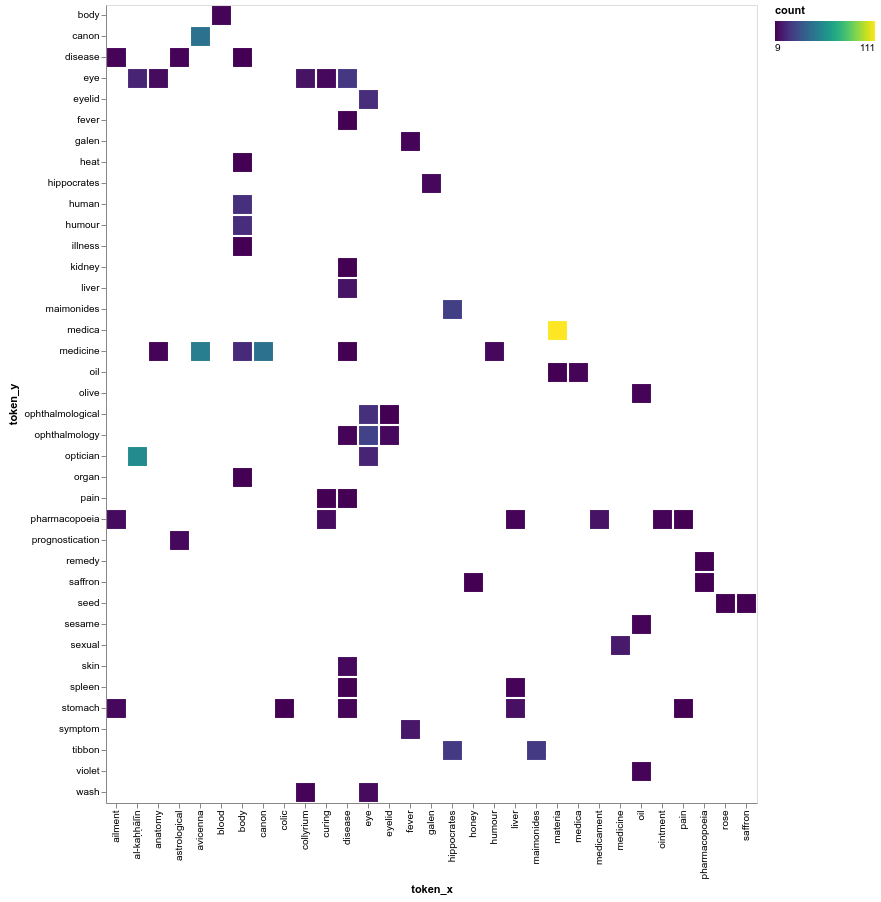

In [25]:
alt.Chart(co_oc_counts[co_oc_counts['count'] > 8]).mark_rect().encode(
    x='token_x:N',
    y='token_y:N',
    color='count:Q'
)

# Edge bundling

In [26]:
import re

def drop_column_suffix(name):
    return re.sub(r'(_[a-z]+)?$', '', name)

In [27]:
drop_column_suffix('foo_x')

'foo'

In [28]:
re.search(r'(_[a-z]+)?$', 'foo_x').groups()

('_x',)

In [29]:
co_oc_counts.head()

,token_x,token_y,count,type_x,type_y
17114,materia,medica,111,ingredient,ingredient
1099,al-kaḥḥālīn,optician,58,authority,treatment
3356,avicenna,medicine,52,authority,treatment
6431,canon,medicine,47,authority,treatment
3272,avicenna,canon,47,authority,authority


In [30]:
# We're going to organise tokens hierachically by category. Using Vega's nest transform
# would seem to be easiest, but it doesn't seem to provide a way to specify node IDs, which
# we need in order to provide the co-occurance relationships. Instead we'll have to provide
# a list of nodes with parent pointers and use the stratisfy transform to produce a tree.

eb_nodes = pd.DataFrame([{'parent': None, 'label': 'root', 'type': 'root'}])

# The pairs we'll include in the visualisation
eb_pairs = co_oc_counts[co_oc_counts['count'] > 6]

eb_leaves = pd.concat(
    [eb_pairs[['token_x', 'type_x']].rename(columns=drop_column_suffix), 
     eb_pairs[['token_y', 'type_y']].rename(columns=drop_column_suffix)]
).drop_duplicates()

_type_nodes = eb_leaves[['type']].drop_duplicates().rename(columns={'type': 'label'})
_type_nodes['parent'] = eb_nodes.iloc[0].name
_type_nodes['type'] = 'category'

eb_nodes = pd.concat([eb_nodes, _type_nodes], ignore_index=True)

eb_leaf_nodes = (
    pd.merge(eb_leaves, 
         eb_nodes[eb_nodes['type'] == 'category'].reset_index()[['index', 'label']], 
         left_on='type', right_on='label')
    [['token', 'index']]
    .rename(columns={'token': 'label', 'index': 'parent'}))
eb_leaf_nodes['type'] = 'token'
eb_leaf_nodes

eb_nodes = pd.concat([eb_nodes, eb_leaf_nodes], ignore_index=True)
eb_nodes.head(10)

,label,parent,type
0,root,None,root
1,ingredient,0,category
2,authority,0,category
3,body_part,0,category
4,ailment,0,category
5,treatment,0,category
6,materia,1,token
7,medica,1,token
8,oil,1,token
9,honey,1,token


In [31]:
# We're going to organise tokens hierachically by category. We'll use Vega's nest transform
# to produce the tree, so we just need to give it a table of token,category pairs

# The pairs we'll include in the visualisation
# eb_pairs = co_oc_counts[co_oc_counts['count'] > 8]

# eb_leaves = pd.concat(
#     [eb_pairs[['token_x', 'type_x']].rename(columns=drop_column_suffix), 
#      eb_pairs[['token_y', 'type_y']].rename(columns=drop_column_suffix)]
# ).drop_duplicates().reset_index(drop=True)
# eb_leaves.index.name = 'id'

# eb_leaves.head()

In [32]:
# We need to give Vega data on the relationships between nodes - the co-occurance frequencies.
# Our links are symmetrical, so we create links in both directions with the same counts.
eb_links_forward = (
    eb_pairs[['token_x', 'token_y', 'count']]
        .rename(columns={'token_x': 'source', 'token_y': 'target'})
        .reset_index(drop=True))
eb_links_backward = (
    eb_links_forward.rename(columns={'source': 'target', 'target': 'source'})
        [['source', 'target', 'count']])

_token_ids = eb_nodes[eb_nodes['type'] == 'token'][['label']].reset_index().set_index('label')

eb_links = pd.concat([
    eb_links_forward, 
#     eb_links_backward
]).sort_index()
eb_links = pd.merge(eb_links, _token_ids.rename(columns=lambda x: 'source_id'), left_on='source', right_index=True)
eb_links = pd.merge(eb_links, _token_ids.rename(columns=lambda x: 'target_id'), left_on='target', right_index=True)
eb_links_ids = eb_links[['source_id', 'target_id', 'count']]

eb_links.head()

,source,target,count,source_id,target_id
0,materia,medica,111,6,7
117,galen,medica,7,30,7
65,materia,oil,9,6,8
40,medica,oil,10,7,8
106,almond,oil,7,14,8


In [33]:
# Create data files for Vega
(eb_nodes
 # Vega expects an id property to identify tree nodes
 .reset_index()
 .to_json('./vega-co-occurance-tree-nodes.json', orient='records'))

eb_links_ids.to_json('./vega-co-occurance-relationships.json', orient='records')

In [34]:
import json

vega_radial_co_occurance_json = {
  "$schema": "https://vega.github.io/schema/vega/v4.json",
  "padding": 5,
  "width": 720,
  "height": 720,
  "autosize": "none",

  "signals": [
    {
      "name": "tension", "value": 0.85,
      "bind": {"input": "range", "min": 0, "max": 1, "step": 0.01}
    },
    {
      "name": "radius", "value": 280,
      "bind": {"input": "range", "min": 20, "max": 400}
    },
    {
      "name": "extent", "value": 360,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "rotate", "value": 0,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "textSize", "value": 10,
      "bind": {"input": "range", "min": 2, "max": 20, "step": 1}
    },
    {
      "name": "textOffset", "value": 8,
      "bind": {"input": "range", "min": 0, "max": 16, "step": 1}
    },
    {
      "name": "layout", "value": "cluster",
      "bind": {"input": "radio", "options": ["tidy", "cluster"]}
    },
    { "name": "colorIn", "value": "forestgreen" },
    { "name": "colorOut", "value": "forestgreen" },
    { "name": "originX", "update": "width / 2" },
    { "name": "originY", "update": "height / 2" },
    {
      "name": "active", "value": None,
      "on": [
        { "events": "text:mouseover", "update": "datum.index" },
        { "events": "mouseover[!event.item]", "update": "null" }
      ]
    }
  ],

  "data": [
    {
      "name": "tree",
      #"url": "vega-co-occurance-leaf-nodes.json",
      "values": json.loads(eb_nodes.reset_index()
                         .to_json(orient='records')),
      "transform": [
        {
          "type": "stratify",
          "key": "index",
          "parentKey": "parent"
        },
        {
          "type": "tree",
          "method": {"signal": "layout"},
          "size": [1, 1],
          "as": ["alpha", "beta", "depth", "children"]
        },
        {
          "type": "formula",
          "expr": "(rotate + extent * datum.alpha + 270) % 360",
          "as":   "angle"
        },
        {
          "type": "formula",
          "expr": "inrange(datum.angle, [90, 270])",
          "as":   "leftside"
        },
        {
          "type": "formula",
          "expr": "originX + radius * datum.beta * cos(PI * datum.angle / 180)",
          "as":   "x"
        },
        {
          "type": "formula",
          "expr": "originY + radius * datum.beta * sin(PI * datum.angle / 180)",
          "as":   "y"
        }
      ]
    },
    {
      "name": "dependencies",
      #"url": "vega-co-occurance-relationships.json",
      "values": json.loads(eb_links_ids.to_json(orient='records')),
      "transform": [
        {
          "type": "formula",
          "expr": "treePath('tree', datum.source_id, datum.target_id)",
          "as":   "treepath",
          "initonly": True
        },
        {
          "type": "formula",
          "as": "is_active",
          "expr": "datum.source_id === active || datum.target_id === active"
        }
      ]
    },
    {
      "name": "selected_links",
      "source": "dependencies",
      "transform": [
        {
          "type": "filter",
          "expr": "datum.is_active"
        }
      ]
    },
    {
      "name": "unselected_links",
      "source": "dependencies",
      "transform": [
        {
          "type": "filter",
          "expr": "!datum.is_active"
        }
      ]
    },
    # - join links
# - collapse src/target
# - filter:
#   - if selected:
#     - 
#   - otherwise:
    {
      "name": "leaves",
      "source": "tree",
      "transform": [
        {
          "type": "filter",
          "expr": "!datum.children"
        },
        {
          "type": "lookup",
          "from": "tree",
          "key": "index",
          "fields": ["parent"],
          "values": ["label"],
          "as": ["group_label"]
        },
        {
          "type": "lookup",
          "from": "selected_links",
#           "from": "dependencies",
          "key": "source_id",
          "fields": ["index"],
          "values": ["count"],
          "as": ["count_src"]
        },
        {
          "type": "lookup",
          "from": "selected_links",
#           "from": "dependencies",
          "key": "target_id",
          "fields": ["index"],
          "values": ["count"],
          "as": ["count_dst"]
        },
        {
          "type": "formula",
          "as": "selected_count",
          "expr": "datum.count_src || datum.count_dst"
        },
        {
          "type": "formula",
          "as": "label_with_count",
          "expr": "datum.label + if(isNumber(datum.selected_count), \" (\" + datum.selected_count + \")\", \"\")"
        }
      ]
    },
    {
      "name": "token_groups",
      "source": "leaves",
      "transform": [
        {
          "type": "aggregate",
          "groupby": ["group_label"],
          "fields": ["alpha", "alpha"],
          "ops": ["min", "max"],
          "as": ["start_alpha", "end_alpha"]
        },
        {
          "type": "formula",
          "expr": "rotate + extent * datum.start_alpha",
          "as":   "start_angle_deg"
        },
        {
          "type": "formula",
          "expr": "rotate + extent * datum.end_alpha",
          "as":   "end_angle_deg"
        },
        {
          "type": "formula",
          "expr": "(PI * (rotate + extent * datum.start_alpha) / 180)",
          "as":   "start_angle"
        },
        {
          "type": "formula",
          "expr": "(PI * (rotate + extent * datum.end_alpha) / 180)",
          "as":   "end_angle"
        }
      ]
    }
  ],

  "marks": [
    {
      "type": "arc",
      "from": {"data": "token_groups"},
      "encode": {
        "enter": {
          "x": {"signal": "originX"},
          "y": {"signal": "originY"},
          "fill": {"scale": "token_type", "field": "group_label"},
          "outerRadius": {"signal": "radius + 6"},
          "innerRadius": {"signal": "radius + 3"},
          "fillOpacity": {"value": 0.5},
          "tooltip": {"field": "group_label"},
#           "padAngle": {"signal": "-PI/90"},
        },
        "update": {
          "startAngle": {"signal": "datum.start_angle - (PI * (extent / 360) / 180)"},
          "endAngle": {"signal": "datum.end_angle + (PI * (extent / 360) / 180)"},
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "leaves"},
      "encode": {
        "enter": {
          "baseline": {"value": "middle"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "dx": {"signal": "textOffset * (datum.leftside ? -1 : 1)"},
          "angle": {"signal": "datum.leftside ? datum.angle - 180 : datum.angle"},
          "align": {"signal": "datum.leftside ? 'right' : 'left'"},
          "fontSize": {"signal": "textSize"},
          "fontWeight": [
#             {"test": "indata('selected', 'source_id', datum.index)", "value": "bold"},
#             {"test": "indata('selected', 'target_id', datum.index)", "value": "bold"},
            {"value": None}
          ],
          "fill": [
#             {"test": "datum.index === active", "value": "black"},
#             {"test": "indata('selected', 'source_id', datum.index)", "signal": "colorIn"},
#             {"test": "indata('selected', 'target_id', datum.index)", "signal": "colorOut"},
              {"test": "indata('selected_links', 'source_id', datum.index)", "scale": "colour2", "field": "selected_count"},
#               {"value": "black"}
              {"scale": "token_type", "field": "group_label"}
          ],
          "opacity": [
            {"test": "indata('selected_links', 'source_id', datum.index)", "value": 1},
            {"test": "indata('selected_links', 'target_id', datum.index)", "value": 1},
            {"test": "active !== null", "value": 0.4},
            {"value": 1}
          ],
          "text": [
              {"test": "datum.index === active", "field": "label"},
              {"field": "label_with_count"}
          ]
        }
      }
    },
    {
      "type": "group",
      "from": {
        "facet": {
          "name":  "path",
          "data":  "selected_links",
          "field": "treepath"
        }
      },
      "zindex": 1,
      "marks": [
        {
          "type": "line",
          "interactive": False,
          "from": {"data": "path"},
          "encode": {
            "enter": {
              "interpolate": {"value": "bundle"},
#               "strokeWidth": {"value": 1.5}
              "strokeWidth": {"scale": "strokeSize", "field": {"parent": "count"}},
              "strokeCap": {"value": "round"},
            },
            "update": {
              "stroke": {"scale": "colour2", "field": {"parent": "count"}},
              "strokeOpacity": [
#                 {"test": "parent.source_id === active || parent.target_id === active", "value": 1},
                {"value": 0.6}
              ],
              "tension": {"signal": "tension"},
              "x": {"field": "x"},
              "y": {"field": "y"}
            }
          }
        }
      ]
    },
    {
      "type": "group",
      "from": {
        "facet": {
          "name":  "path",
          "data":  "unselected_links",
          "field": "treepath"
        }
      },
      "zindex": 0,
      "marks": [
        {
          "type": "line",
          "interactive": False,
          "from": {"data": "path"},
          "encode": {
            "enter": {
              "interpolate": {"value": "bundle"},
              "strokeWidth": {"scale": "strokeSize", "field": {"parent": "count"}},
              "strokeCap": {"value": "round"},
            },
            "update": {
#               "stroke": {"value": "steelblue"},
              "stroke": {"value": "#538fc1"},
              "strokeOpacity": [
                  {"test": "active !== null", "value": 0.05},
                  {"value": 0.2}
              ],
              "tension": {"signal": "tension"},
              "x": {"field": "x"},
              "y": {"field": "y"}
            }
          }
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": ["depends on", "imported by"],
      "range": [{"signal": "colorIn"}, {"signal": "colorOut"}]
    },
    {
      "name": "colour2",
      "type": "linear",
      "domain": {"data": "dependencies", "field": "count"},
#       "range": {"scheme": "orangered"}
      "range": ["#fdbb84", "#7f0000"]
    },
    {
      "name": "strokeSize",
      "type": "linear",
      "zero": True,
      "domain": {"data": "dependencies", "field": "count"},
      "range": [1.5, 5]
    },
    {
      "name": "token_type",
      "type": "ordinal",
      "domain": {"data": "token_groups", "field": "group_label"},
#       "range": {"scheme": "category10"}
      "range": ["#2ca02c", "#d62728", "#724F91", "#8c564b", "#656612"]
    }
  ],

  "legends": [
#     {
#       "stroke": "color",
#       "orient": "bottom-right",
#       "title": "Dependencies",
#       "encode": {
#         "symbols": {
#           "enter": {
#             "shape": {"value": "M-0.5,0H1"}
#           }
#         }
#       }
#     },
    {
      "fill": "colour2",
      "type": "gradient",
      "orient": "bottom-right",
      "title": "Co-occurrence frequency",
    },
    {
      "fill": "token_type",
      "type": "symbol",
      "orient": "top-right",
      "title": "Token types",
    }
  ]
}

import json
json.dump(vega_radial_co_occurance_json, open('./_vega_radial.json', 'w'),
          indent=2)


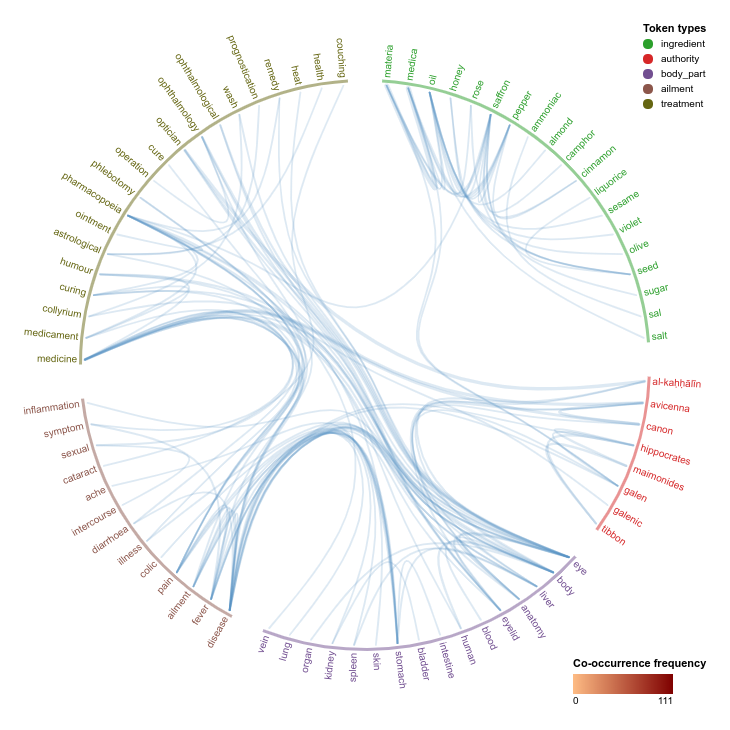

In [35]:
alt.vega.v3.vega(vega_radial_co_occurance_json)

# Test...

In [36]:
df = pd.DataFrame({'a': ['a', 'b', 'c', 'a', 'c', 'b', 'a'], 
                   'b': ['1', '1', '1', '2', '2', '3', '3']})
df

,a,b
0,a,1
1,b,1
2,c,1
3,a,2
4,c,2
5,b,3
6,a,3


a, b
a, c,
b, c
a, c
a, b

In [37]:
dfm = pd.merge(df, df, how='left', on='b')
dfm

,a_x,b,a_y
0,a,1,a
1,a,1,b
2,a,1,c
3,b,1,a
4,b,1,b
5,b,1,c
6,c,1,a
7,c,1,b
8,c,1,c
9,a,2,a


In [38]:
# Remove co-occurance with self
dfm1 = dfm[dfm['b_x'] != dfm['b_y']]
dfm1

KeyError: 'b_x'

In [ ]:
dfm2 = dfm1[['b_x', 'b_y']].reset_index().melt(id_vars=['index']).sort_values(['index', 'value']).set_index('index')[['value']]
dfm2

In [ ]:
pd.concat([dfm2[0::2], 
           dfm2[1::2]], axis=1)

In [ ]:
pd.Series(range(len(dfm2))) % 2 == 0

In [ ]:
dfm1[['b_x', 'b_y']].stack().reset_index(1, drop=True).reset_index()

In [ ]:
dfm1[['b_x', 'b_y']].sort_values(by=list(range(15)), ascending=True, axis=1)

In [ ]:
b_max = dfm1[['b_x', 'b_y']].max(axis='columns', numeric_only=False)
b_min = dfm1[['b_x', 'b_y']].min(axis='columns', numeric_only=False)

In [ ]:
pd.concat([dfm1['a'], b_min, b_max], axis=1).drop_duplicates()

### Matrix

In [ ]:
import altair as alt
import numpy as np
import pandas as pd

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(-5, 5), range(-5, 5))
z = x ** 2 + y ** 2

# Convert this grid to columnar data expected by Altair
data = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})
data

In [ ]:
alt.Chart(data).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)